In [1]:
RESULT_DIR = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"
# RESULT_DIR = "/home/niko/Downloads/results"

In [2]:
import os
import sys
sys.path.append("..")

import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.eval.SampleResult import SampleResult

In [3]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith("final.json")]

# get ids from the first part of the filename separated by "_"
file_ids = [f.split("_")[0] for f in files]

samples = [SampleResult.load_by_id(RESULT_DIR, file_id) for file_id in file_ids]

In [4]:
df = pd.DataFrame()

# Evaluation Parameters

In [5]:
ALIGNMENT_SEQUENCE = "mfa"
TEMPORAL_ALIGNMENT_TOLERANCE = 0.1
ALIGNMENT_WORD_NORMALIZATION = True     # No difference

In [6]:
eval = pd.Series()
eval["num_samples"] = len(samples)
eval["alignment_sequence"] = ALIGNMENT_SEQUENCE
eval["alignment_word_normalization"] = ALIGNMENT_WORD_NORMALIZATION
eval["temporal_alignment_tolerance"] = TEMPORAL_ALIGNMENT_TOLERANCE

## Alignments

Build the alignments relative to either the `final` sequence of the online, or the `baseline` with offline transcription.

In [7]:
_alignment_sequences = [s.final if ALIGNMENT_SEQUENCE == "final"
                        else s.mfa if ALIGNMENT_SEQUENCE == "mfa"
                        else s.baseline if ALIGNMENT_SEQUENCE == "baseline"
                        else None
                        for s in samples]

for sample in samples:
    sample.build_alignments(normalize_words=ALIGNMENT_WORD_NORMALIZATION,
                            align_to=ALIGNMENT_SEQUENCE,
                            temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE)

In [8]:
samples_df = pd.DataFrame([{
    "id": sample.sample_id,
    "sample": sample,
    "word_count_final": len(sample.final),
    "word_count_baseline": len(sample.baseline),
    "word_count_transcript": len(sample.transcript),
} for sample in samples])
samples_df

,id,sample,word_count_final,word_count_baseline,word_count_transcript
0,7127-75946-0000,<src.eval.SampleResult.SampleResult object at ...,496,605,604
1,908-31957-0000,<src.eval.SampleResult.SampleResult object at ...,450,466,472
2,5142-33396-0000,<src.eval.SampleResult.SampleResult object at ...,799,921,941
3,2094-142345-0000,<src.eval.SampleResult.SampleResult object at ...,1055,1082,1159
4,121-123852-0000,<src.eval.SampleResult.SampleResult object at ...,122,116,115
...,...,...,...,...,...
78,908-157963-0000,<src.eval.SampleResult.SampleResult object at ...,513,604,621
79,3570-5694-0000,<src.eval.SampleResult.SampleResult object at ...,521,616,614
80,7021-85628-0000,<src.eval.SampleResult.SampleResult object at ...,470,475,477
81,4992-41806-0000,<src.eval.SampleResult.SampleResult object at ...,362,368,384


In [9]:
def total_partial_words(sample: SampleResult) -> int:
    partial_words = [len(partial.result) for partial in sample.partials]
    return sum(partial_words)

def unaligned_partial_words(sample: SampleResult) -> int:
    unalignments = [len(alignements.unalignments) for alignements in sample.alignments]
    return sum(unalignments)

samples_df["unaligned_partial_count"] = samples_df["sample"].apply(unaligned_partial_words)
samples_df["partial_count"] = samples_df["sample"].apply(total_partial_words)

eval["total_partial_count"] = samples_df["partial_count"].sum().item()
eval["unaligned_partial_count"] = samples_df["unaligned_partial_count"].sum().item()

## Word first correct

The word first correct (wfc) is defined as the first correct occurence of a word.

In [10]:
from src.eval.metrics.word_first_correct import word_first_correct_response
wfc = [[word_first_correct_response(_alignment_sequences[j], s.partials, i, s.alignments) for i in range(len(_alignment_sequences[j]))] for j, s in enumerate(samples)]

In [11]:
total_wfc = np.concat(wfc)
wfc_latency = np.array([r["latency"] for r in total_wfc if r is not None])
none_wfc_count = len(total_wfc) - len(wfc_latency)
print("None values in wfc: ", none_wfc_count, f"({none_wfc_count / len(total_wfc) * 100:.2f}%)")
eval["wfc_none_count"] = none_wfc_count

None values in wfc:  782 (1.61%)


In [12]:
print("Min:", np.min(wfc_latency))
print("Max:", np.max(wfc_latency))
print("Mean:", np.mean(wfc_latency))
print("Median:", np.median(wfc_latency))
print("Std:", np.std(wfc_latency))
print("P95:", np.percentile(wfc_latency, 95))
print("P99:", np.percentile(wfc_latency, 99))

eval["wfc_latency_min"] = np.min(wfc_latency).item()
eval["wfc_latency_max"] = np.max(wfc_latency).item()
eval["wfc_latency_mean"] = np.mean(wfc_latency).item()
eval["wfc_latency_std"] = np.std(wfc_latency).item()
eval["wfc_latency_median"] = np.median(wfc_latency).item()
eval["wfc_latency_negative_count"] = len([x for x in wfc_latency if x < 0])
eval["wfc_latency_p95"] = np.percentile(wfc_latency, 95).item()
eval["wfc_latency_p99"] = np.percentile(wfc_latency, 99).item()
eval["wfc_latency_count"] = len(wfc_latency)

Min: -0.45125926077365364
Max: 32.498076221048834
Mean: 2.539952005387154
Median: 2.059881272129722
Std: 1.6596359731592276
P95: 5.850681273695084
P99: 9.848252259619539


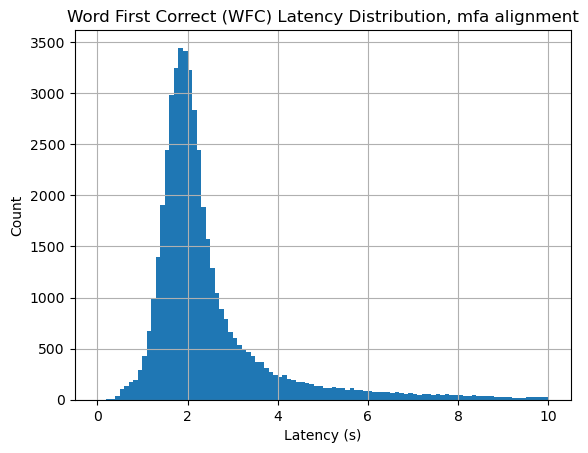

In [13]:
plt.hist(wfc_latency,
         bins=100,
         range=(math.floor(np.percentile(wfc_latency, 1)), math.ceil(np.percentile(wfc_latency, 99).item()))
         )
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title(f"Word First Correct (WFC) Latency Distribution, {ALIGNMENT_SEQUENCE} alignment")
plt.grid()

## Word first final

The word first final (wff) is defined as the first occurence after which a word will never change to a different prediction.

In [14]:
from src.eval.metrics.word_first_final import word_first_final_response
wff = [[word_first_final_response(_alignment_sequences[j], s.partials, i, s.alignments) for i in range(len(_alignment_sequences[j]))] for j, s in enumerate(samples)]

In [15]:
total_wff = np.concat(wff)
wff_latency = np.array([r["latency"] for r in total_wff if r is not None])
none_wff_count = len(total_wff) - len(wff_latency)
print("None values in wff: ", none_wff_count, f"({none_wff_count / len(total_wff) * 100:.2f}%)")
eval["wff_none_count"] = none_wff_count

None values in wff:  782 (1.61%)


In [16]:
print("Min:", np.min(wff_latency))
print("Max:", np.max(wff_latency))
print("Mean:", np.mean(wff_latency))
print("Median:", np.median(wff_latency))
print("Std:", np.std(wff_latency))
print("P95:", np.percentile(wff_latency, 95))
print("P99:", np.percentile(wff_latency, 99))

eval["wff_latency_min"] = np.min(wff_latency).item()
eval["wff_latency_max"] = np.max(wff_latency).item()
eval["wff_latency_mean"] = np.mean(wff_latency).item()
eval["wff_latency_std"] = np.std(wff_latency).item()
eval["wff_latency_median"] = np.median(wff_latency).item()
eval["wff_latency_negative_count"] = len([x for x in wff_latency if x < 0])
eval["wff_latency_p95"] = np.percentile(wff_latency, 95).item()
eval["wff_latency_p99"] = np.percentile(wff_latency, 99).item()
eval["wff_latency_count"] = len(wff_latency)

Min: 0.2693989352881907
Max: 143.71088769987225
Mean: 8.572810261303406
Median: 6.02141510009767
Std: 9.619780847324249
P95: 18.834755151271832
P99: 30.256388988077642


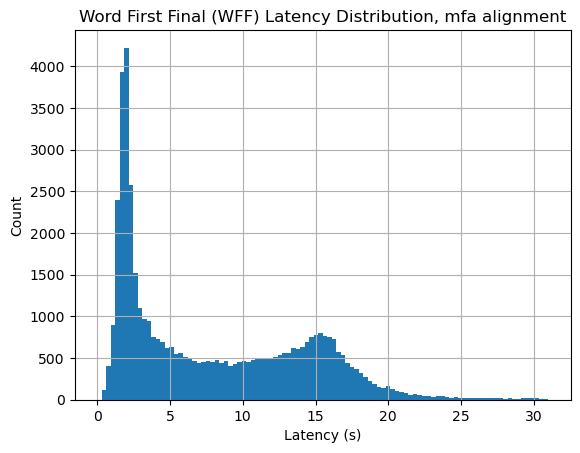

In [17]:
plt.hist(wff_latency, bins=100, range=(math.floor(np.percentile(wff_latency, 1)), math.ceil(np.percentile(wff_latency, 99).item())))
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title(f"Word First Final (WFF) Latency Distribution, {ALIGNMENT_SEQUENCE} alignment")
plt.grid()

In [18]:
df = pd.concat([df, eval.to_frame().T], ignore_index=True)

## Visualize Alignment

In [19]:
id = "7127-75946-0000"
sample = next(s for s in samples if s.sample_id == id)

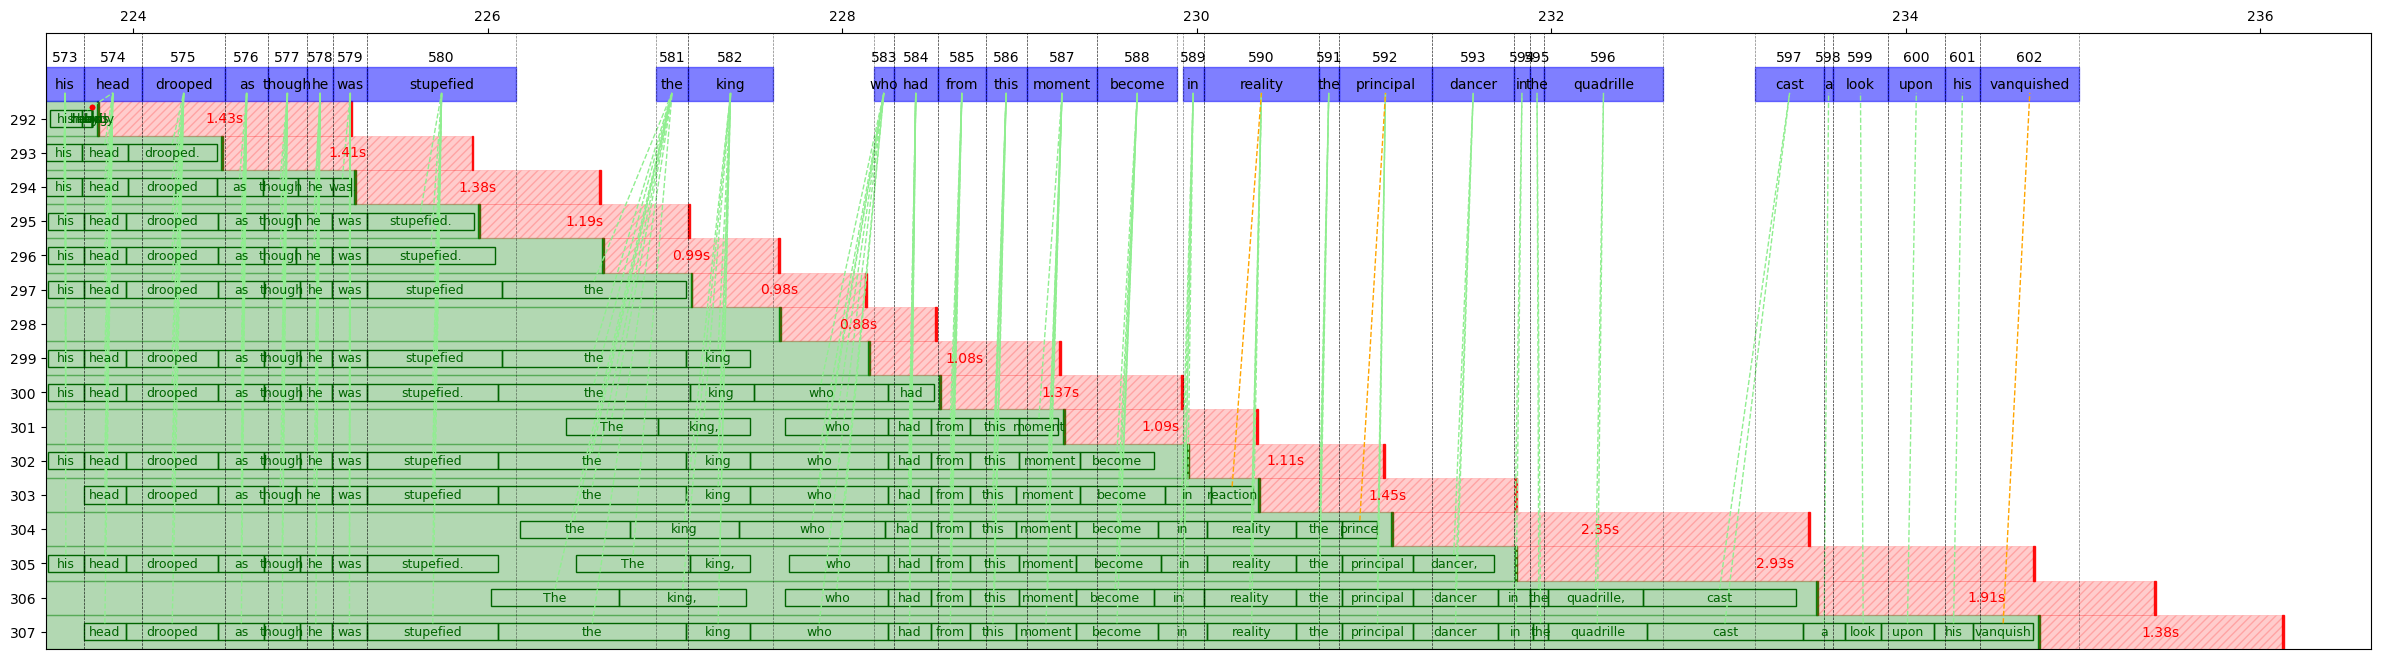

In [26]:
from matplotlib.patches import Rectangle

DRAW_CONFIRMED_ALIGNMENTS = False

_alignment_sequence = (sample.final if ALIGNMENT_SEQUENCE == "final"
                        else sample.mfa if ALIGNMENT_SEQUENCE == "mfa"
                        else sample.baseline if ALIGNMENT_SEQUENCE == "baseline"
                        else None)

start_indices = {
    "baseline": 473,
    "final": 574,
    "mfa": 573
}

window_length = 30
window_start = start_indices[ALIGNMENT_SEQUENCE]
window_end = window_start + window_length

words = _alignment_sequence[window_start:window_end]

window_start_t = words[0].start
window_end_t = words[-1].end

# Filter predictions and keep original indices
indexed_predictions = [
    (i, p) for i, p in enumerate(sample.partials)
    if window_start_t <= p.window[1] and (p.observation_time <= window_end_t or p.window[1] <= window_end_t)
]
indexed_predictions = indexed_predictions[::-1]  # Reverse for display

# Final word mapping (global indices to x/y coordinates)
final_word_positions = {
    i: {
        "x": (word.start + word.end) / 2,
        "y": len(indexed_predictions) + 0.25  # fixed y for final row
    }
    for i, word in enumerate(_alignment_sequence)
}

# Determine max observation time for x-axis limit
max_obs_time = max(window_end_t, max(p.observation_time for _, p in indexed_predictions))

fig, ax = plt.subplots(figsize=(30, 8))

for row_index, (original_index, partial) in enumerate(indexed_predictions):
    win_start, win_end = partial.window
    obs_time = partial.observation_time

    # Green prediction window
    ax.add_patch(Rectangle((win_start, row_index), win_end - win_start, 1, color="green", alpha=0.3))

    marker_width = 0.01
    ax.add_patch(Rectangle((win_end - marker_width / 2, row_index), marker_width, 1, color="green", alpha=0.9))

    # Red delay box
    if obs_time > win_end:
        delay = obs_time - win_end
        ax.add_patch(Rectangle(
            (win_end, row_index), delay, 1,
            color="red", alpha=0.2, hatch='////', linewidth=0.5, fill=True
        ))
        # Delay label
        ax.text(win_end + delay / 2, row_index + 0.5, f"{delay:.2f}s", ha="center", va="center", fontsize=10, color="red")

    ax.add_patch(Rectangle((obs_time - marker_width / 2, row_index), marker_width, 1, color="red", alpha=0.9))

    # Word boxes
    for word_index, word in enumerate(partial.result):
        if window_start_t <= word.start <= window_end_t:
            ax.add_patch(Rectangle(
                (word.start, row_index + 0.25), word.end - word.start, 0.5,
                edgecolor="darkgreen", facecolor="none", linewidth=1
            ))
            ax.text((word.start + word.end) / 2, row_index + 0.5, word.word,
                    ha="center", va="center", fontsize=9, color="darkgreen")
            
            # Draw alignment line
            wa = None
            accepted = False
            if DRAW_CONFIRMED_ALIGNMENTS:
                for _wa in sample.alignments[original_index].confirmed_alignments:
                    if _wa.partial_word_index == word_index:
                        wa = _wa
                        break
            for _wa in sample.alignments[original_index].accepted_alignments:
                if _wa.partial_word_index == word_index:
                    wa = _wa
                    accepted = True
                    break
            if wa is None and not DRAW_CONFIRMED_ALIGNMENTS:
                for _wa in sample.alignments[original_index].potential_alignments:
                    if _wa.partial_word_index == word_index:
                        wa = _wa
                        break
            if wa is not None:
                if wa.final_word_index in final_word_positions:
                    x0 = (word.start + word.end) / 2
                    y0 = row_index + 0.75
                    x1 = final_word_positions[wa.final_word_index]["x"]
                    y1 = final_word_positions[wa.final_word_index]["y"]
                    color = "blue" if DRAW_CONFIRMED_ALIGNMENTS else "lightgreen" if accepted else "orange"
                    ax.plot([x0, x1], [y0, y1], color=color, linestyle="dashed", linewidth=1)
            else:
                ax.plot((word.start + word.end) / 2, row_index + 0.85, "o", color="red", markersize=3, alpha=0.5)
            

# Draw top word layer (blue)
word_y = len(indexed_predictions)
for i, word in enumerate(words):
    start = word.start
    end = word.end
    ax.add_patch(Rectangle((start, word_y), end - start, 1, color="blue", alpha=0.5))
    ax.text((start + end) / 2, word_y + 0.5, word.word, ha="center", va="center", fontsize=10)
    ax.text((start + end) / 2, word_y + 1.3, f"{window_start + i}", ha="center", va="center", fontsize=10, color="black")
    ax.axvline(start, color="black", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.axvline(end, color="black", linestyle="--", linewidth=0.5, alpha=0.5)

window_end_t = max_obs_time + 0.5

# Axes setup
ax.set_xlim(window_start_t, window_end_t)
ax.set_ylim(0, word_y + 2)
ax.set_yticks([i + 0.5 for i in range(len(indexed_predictions))])
ax.set_yticklabels([str(idx) for idx, _ in indexed_predictions])
ax.xaxis.tick_top()

plt.show()

# Automated alignment evaluation

In [ ]:
from tqdm import tqdm

In [ ]:
metrics_df = pd.DataFrame()

In [ ]:
ALIGNMENT_SEQUENCES = ["final", "baseline"]
TEMPORAL_ALIGNMENT_TOLERANCES = [0.0, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]

In [ ]:
for ALIGNMENT_SEQUENCE in ALIGNMENT_SEQUENCES:
    print(f"Evaluating {ALIGNMENT_SEQUENCE} alignments")
    for TEMPORAL_ALIGNMENT_TOLERANCE in tqdm(TEMPORAL_ALIGNMENT_TOLERANCES):
        _alignment_sequences = [s.final if ALIGNMENT_SEQUENCE == "final"
                                else s.mfa if ALIGNMENT_SEQUENCE == "mfa"
                                else s.baseline if ALIGNMENT_SEQUENCE == "baseline"
                                else None
                                for s in samples]

        t0 = time.perf_counter()

        for sample in samples:
            sample.build_alignments(normalize_words=ALIGNMENT_WORD_NORMALIZATION,
                                    align_to=ALIGNMENT_SEQUENCE,
                                    temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE)
            
        t1 = time.perf_counter()
        
        eval = pd.Series()
        eval["alignment_sequence"] = ALIGNMENT_SEQUENCE
        eval["temporal_alignment_tolerance"] = TEMPORAL_ALIGNMENT_TOLERANCE
        eval["alignments"] = [s.alignments for s in samples]

        eval["unaligned_partial_words"] = sum([unaligned_partial_words(s) for s in samples])

        t2 = time.perf_counter()

        wfc = [[word_first_correct_response(_alignment_sequences[j], s.partials, i, s.alignments) for i in range(len(_alignment_sequences[j]))] for j, s in enumerate(samples)]
        total_wfc = np.concat(wfc)
        eval["wfc_latency"] = np.array([r["latency"] for r in total_wfc if r is not None])

        t3 = time.perf_counter()

        wff = [[word_first_final_response(_alignment_sequences[j], s.partials, i, s.alignments) for i in range(len(_alignment_sequences[j]))] for j, s in enumerate(samples)]
        total_wff = np.concat(wff)
        eval["wff_latency"] = np.array([r["latency"] for r in total_wff if r is not None])

        t4 = time.perf_counter()

        metrics_df = pd.concat([metrics_df, eval.to_frame().T], ignore_index=True)

metrics_df.sort_values(by=["alignment_sequence", "temporal_alignment_tolerance"], inplace=True)
metrics_df.info()


Evaluating final alignments


100%|██████████| 7/7 [03:12<00:00, 27.49s/it]


Evaluating baseline alignments


100%|██████████| 7/7 [03:51<00:00, 33.03s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 7 to 6
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   alignment_sequence            14 non-null     object
 1   temporal_alignment_tolerance  14 non-null     object
 2   alignments                    14 non-null     object
 3   unaligned_partial_words       14 non-null     object
 4   wfc_latency                   14 non-null     object
 5   wff_latency                   14 non-null     object
dtypes: object(6)
memory usage: 784.0+ bytes


In [ ]:
metrics_df

,alignment_sequence,temporal_alignment_tolerance,alignments,unaligned_partial_words,wfc_latency,wff_latency,wfc_latency_min,wfc_latency_max,wfc_latency_mean,wfc_latency_mean_excl_neg,...,wfc_latency_p95,wfc_latency_p99,wff_latency_min,wff_latency_max,wff_latency_mean,wff_latency_std,wff_latency_median,wff_latency_negative_count,wff_latency_p95,wff_latency_p99
7,baseline,0.0,[[<src.eval.PredictionAlignment.PredictionAlig...,2729,"[1.035239720568061, 0.7952397205680608, 0.6552...","[11.867625450566411, 16.74449127547443, 16.604...",-7.019370,80.207663,2.687620,2.688325,...,6.101828,10.356817,-7.019370,147.220888,9.592683,9.633971,8.530071,1,19.083471,30.034859
8,baseline,0.05,[[<src.eval.PredictionAlignment.PredictionAlig...,7562,"[2.121731370911002, 0.6341608881205321, 0.4941...","[2.121731370911002, 0.6341608881205321, 0.4941...",-7.019370,80.207663,2.622640,2.623254,...,5.845779,9.758487,-7.019370,143.800888,8.628390,9.630792,6.099224,1,18.812568,30.469909
9,baseline,0.1,[[<src.eval.PredictionAlignment.PredictionAlig...,6813,"[2.121731370911002, 0.6341608881205321, 0.4941...","[2.121731370911002, 0.6341608881205321, 0.4941...",-7.019370,80.207663,2.621661,2.622275,...,5.844915,9.751718,-7.019370,143.800888,8.644368,9.628717,6.113847,1,18.861358,30.469909
10,baseline,0.5,[[<src.eval.PredictionAlignment.PredictionAlig...,3852,"[1.114160888120532, 0.6341608881205321, 0.4941...","[1.114160888120532, 0.6341608881205321, 0.4941...",-7.019370,80.207663,2.614851,2.616316,...,5.830359,9.746719,-0.230601,143.800888,8.719840,9.667451,6.209571,2,19.017417,30.718903
11,baseline,1.0,[[<src.eval.PredictionAlignment.PredictionAlig...,3052,"[1.114160888120532, 0.6341608881205321, 0.4941...","[1.114160888120532, 0.6341608881205321, 0.4941...",-7.019370,80.207663,2.608049,2.612321,...,5.825940,9.726517,-0.441041,143.800888,8.743634,9.655368,6.258432,3,19.078408,30.705349
12,baseline,2.0,[[<src.eval.PredictionAlignment.PredictionAlig...,2877,"[1.114160888120532, 0.6341608881205321, 0.4941...","[1.114160888120532, 0.6341608881205321, 0.4941...",-7.019370,80.207663,2.597865,2.617297,...,5.845255,9.809781,-1.318233,143.800888,8.793071,9.672932,6.346526,7,19.159709,30.707060
13,baseline,5.0,[[<src.eval.PredictionAlignment.PredictionAlig...,2448,"[1.114160888120532, 0.6341608881205321, 0.4941...","[1.114160888120532, 0.6341608881205321, 0.4941...",-7.019370,80.207663,2.590061,2.691140,...,6.165433,10.726998,-6.372513,147.220888,9.160203,9.778115,7.094810,46,19.942262,31.014310
0,final,0.0,[[<src.eval.PredictionAlignment.PredictionAlig...,5600,"[1.041731370911002, 0.7617313709110021, 11.388...","[15.973553719297051, 15.693553719297052, 15.57...",-122.836773,87.187745,1.875155,2.634281,...,5.150325,9.064060,-122.836773,402.788918,7.999893,12.375858,5.960889,1115,18.750812,30.718930
1,final,0.05,[[<src.eval.PredictionAlignment.PredictionAlig...,9359,"[2.121731370911002, 0.6341608881205321, 0.4941...","[2.121731370911002, 0.6341608881205321, 0.4941...",-122.836773,122.385076,1.825342,2.567705,...,4.854189,8.378115,-122.836773,402.788918,7.482455,12.395560,4.811029,1096,18.573735,30.948077
2,final,0.1,[[<src.eval.PredictionAlignment.PredictionAlig...,9021,"[2.121731370911002, 0.6341608881205321, 0.4941...","[2.121731370911002, 0.6341608881205321, 0.4941...",-122.836773,122.385076,1.824395,2.567119,...,4.853491,8.375721,-122.836773,402.788918,7.501613,12.389899,4.822226,1105,18.617950,30.835787


In [ ]:

metrics_df["accepted_alignments_count"] = metrics_df["alignments"].apply(lambda x: sum([sum([len(a.accepted_alignments) for a in p]) for p in x]))
metrics_df["confirmed_alignments_count"] = metrics_df["alignments"].apply(lambda x: sum([sum([len(a.confirmed_alignments) for a in p]) for p in x]))
metrics_df["accepted_alignments_ratio"] = metrics_df["accepted_alignments_count"] / metrics_df["confirmed_alignments_count"]

metrics_df["wfc_latency_min"] = metrics_df["wfc_latency"].apply(lambda x: np.min(x) if len(x) > 0 else None)
metrics_df["wfc_latency_max"] = metrics_df["wfc_latency"].apply(lambda x: np.max(x) if len(x) > 0 else None)
metrics_df["wfc_latency_mean"] = metrics_df["wfc_latency"].apply(lambda x: np.mean(x) if len(x) > 0 else None)
metrics_df["wfc_latency_mean_excl_neg"] = metrics_df["wfc_latency"].apply(lambda x: np.mean([i for i in x if i >= 0]) if len(x) > 0 else None)
metrics_df["wfc_latency_mean_neg"] = metrics_df["wfc_latency"].apply(lambda x: np.mean([i for i in x if i < 0]) if len(x) > 0 else None)
metrics_df["wfc_latency_std"] = metrics_df["wfc_latency"].apply(lambda x: np.std(x) if len(x) > 0 else None)
metrics_df["wfc_latency_median"] = metrics_df["wfc_latency"].apply(lambda x: np.median(x) if len(x) > 0 else None)
metrics_df["wfc_latency_negative_count"] = metrics_df["wfc_latency"].apply(lambda x: len([i for i in x if i < 0]) if len(x) > 0 else None)
metrics_df["wfc_latency_p95"] = metrics_df["wfc_latency"].apply(lambda x: np.percentile(x, 95) if len(x) > 0 else None)
metrics_df["wfc_latency_p99"] = metrics_df["wfc_latency"].apply(lambda x: np.percentile(x, 99) if len(x) > 0 else None)

metrics_df["wff_latency_min"] = metrics_df["wff_latency"].apply(lambda x: np.min(x) if len(x) > 0 else None)
metrics_df["wff_latency_max"] = metrics_df["wff_latency"].apply(lambda x: np.max(x) if len(x) > 0 else None)
metrics_df["wff_latency_mean"] = metrics_df["wff_latency"].apply(lambda x: np.mean(x) if len(x) > 0 else None)
metrics_df["wff_latency_std"] = metrics_df["wff_latency"].apply(lambda x: np.std(x) if len(x) > 0 else None)
metrics_df["wff_latency_median"] = metrics_df["wff_latency"].apply(lambda x: np.median(x) if len(x) > 0 else None)
metrics_df["wff_latency_negative_count"] = metrics_df["wff_latency"].apply(lambda x: len([i for i in x if i < 0]) if len(x) > 0 else None)
metrics_df["wff_latency_p95"] = metrics_df["wff_latency"].apply(lambda x: np.percentile(x, 95) if len(x) > 0 else None)
metrics_df["wff_latency_p99"] = metrics_df["wff_latency"].apply(lambda x: np.percentile(x, 99) if len(x) > 0 else None)

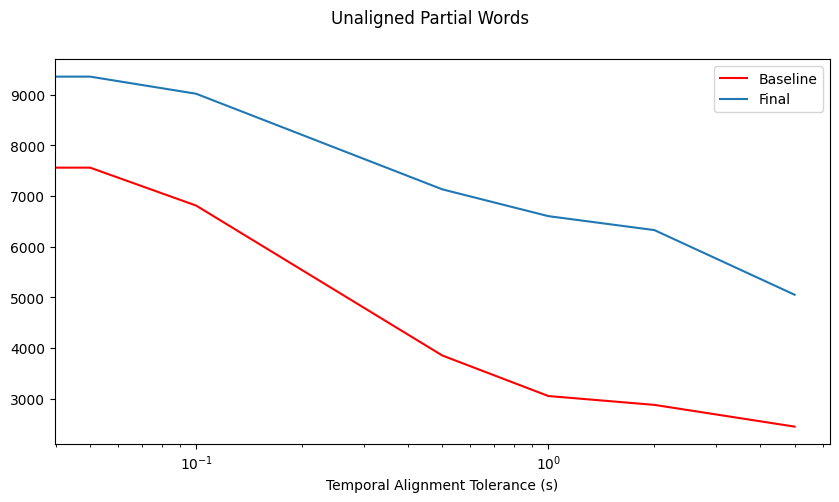

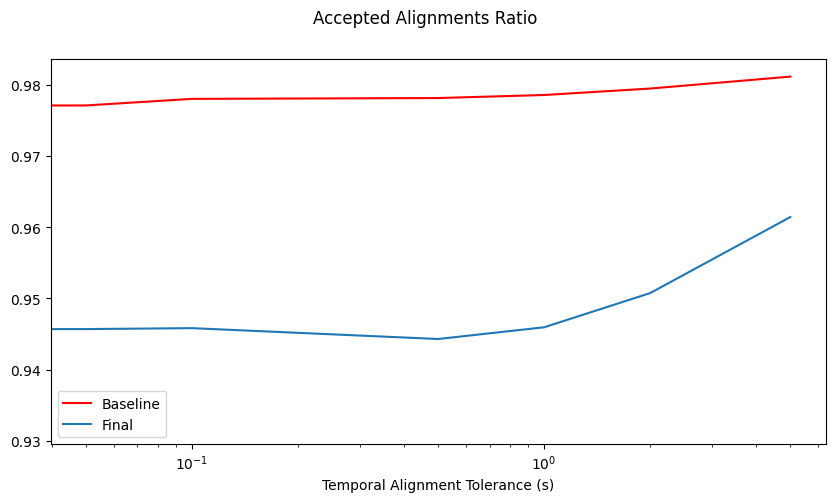

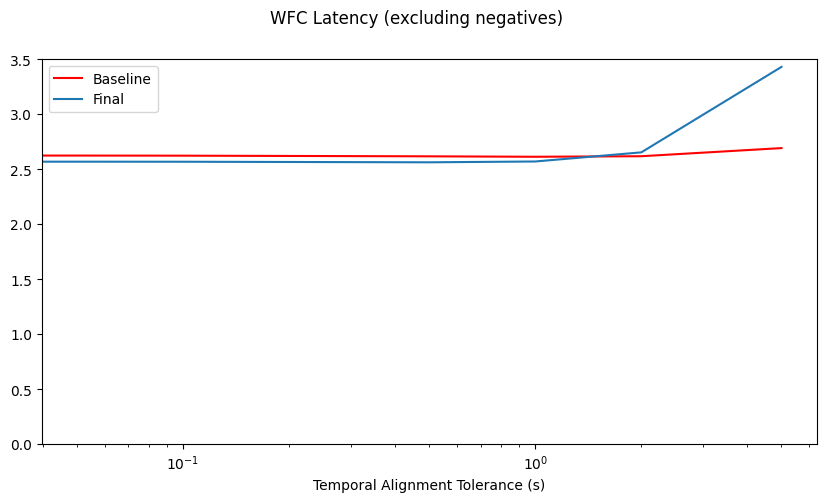

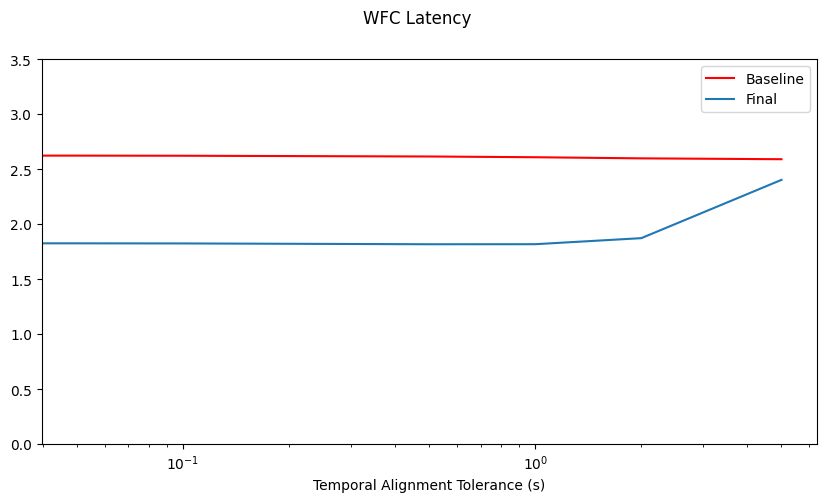

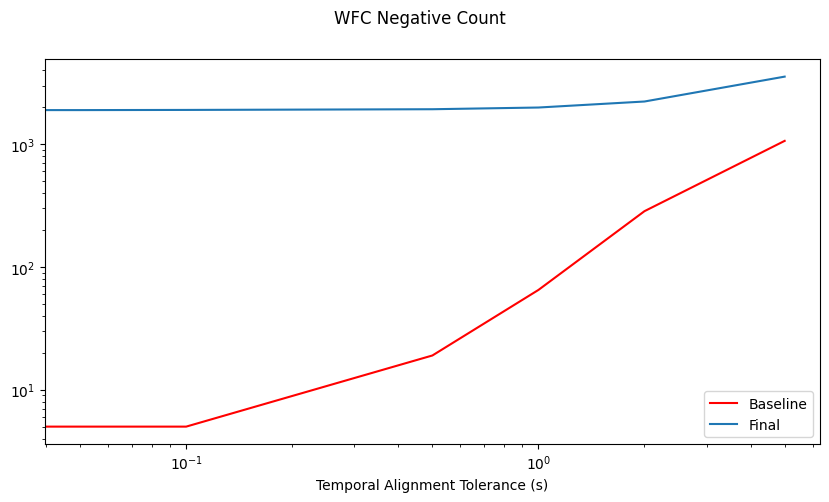

In [ ]:
baseline_df = metrics_df[metrics_df["alignment_sequence"] == "baseline"]
final_df = metrics_df[metrics_df["alignment_sequence"] == "final"]

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Unaligned Partial Words")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
ax.set_xscale("log")
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["unaligned_partial_words"], color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["unaligned_partial_words"])
ax.legend(["Baseline", "Final"])

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Accepted Alignments Ratio")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
ax.set_xscale("log")
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["accepted_alignments_ratio"], color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["accepted_alignments_ratio"])
ax.legend(["Baseline", "Final"])

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("WFC Latency (excluding negatives)")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
ax.set_xscale("log")
ax.set_ylim(ymin=0, ymax=3.5)
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["wfc_latency_mean_excl_neg"], color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["wfc_latency_mean_excl_neg"])
ax.legend(["Baseline", "Final"])

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("WFC Latency")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
ax.set_xscale("log")
ax.set_ylim(ymin=0, ymax=3.5)
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["wfc_latency_mean"], color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["wfc_latency_mean"])
ax.legend(["Baseline", "Final"])

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("WFC Negative Count")
ax.set_xlabel("Temporal Alignment Tolerance (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(baseline_df["temporal_alignment_tolerance"], baseline_df["wfc_latency_negative_count"], color="red")
ax.plot(final_df["temporal_alignment_tolerance"], final_df["wfc_latency_negative_count"])
ax.legend(["Baseline", "Final"])

plt.show()

In [ ]:
metrics_df[["alignment_sequence", "temporal_alignment_tolerance", "wfc_latency_mean", "wfc_latency_negative_count", "wfc_latency_mean_neg"]]

,alignment_sequence,temporal_alignment_tolerance,wfc_latency_mean,wfc_latency_negative_count,wfc_latency_mean_neg
7,baseline,0.0,2.687620,6,-2.884235
8,baseline,0.05,2.622640,5,-3.232556
9,baseline,0.1,2.621661,5,-3.232556
10,baseline,0.5,2.614851,19,-1.059832
11,baseline,1.0,2.608049,65,-0.520939
12,baseline,2.0,2.597865,285,-0.632876
13,baseline,5.0,2.590061,1066,-1.816041
0,final,0.0,1.875155,1952,-13.339658
1,final,0.05,1.825342,1899,-13.684523
2,final,0.1,1.824395,1905,-13.641426
